In [99]:
import numpy as np
import pandas as pd
import os
import json
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from ipywidgets import interactive
from collections import defaultdict, Counter
from kneed import KneeLocator
from sklearn.metrics.pairwise import haversine_distances, euclidean_distances
import folium
import re
%matplotlib inline
inline_rc = dict(mpl.rcParams)

In [2]:
# conda install -c conda-forge hdbscan

Read in Business Data

In [3]:
df_business = pd.read_csv('data/csv_files/business.csv')

Check Data

In [4]:
df_business.head()

,id,alias,name,image_url,url,review_count,categories1,categories2,categories3,rating,...,transactions1,transactions2,transactions3,address1,address2,address3,city,zip_code,api_search_zip,api_search_offset
0,FaR-Kv-0ZzgcqFW1sCnacw,citizens-of-chelsea-new-york,Citizens Of Chelsea,https://s3-media4.fl.yelpcdn.com/bphoto/-UEMxN...,https://www.yelp.com/biz/citizens-of-chelsea-n...,1028,coffee,breakfast_brunch,australian,4.0,...,delivery,pickup,NaN,401 W 25th St,NaN,NaN,New York,10001,10001,0
1,IOHaEgK1zDvUvB3SfKuGCw,parker-and-quinn-new-york,Parker & Quinn,https://s3-media4.fl.yelpcdn.com/bphoto/6xuN0y...,https://www.yelp.com/biz/parker-and-quinn-new-...,1647,newamerican,bars,breakfast_brunch,4.0,...,delivery,pickup,NaN,64 W 39th St,NaN,NaN,New York,10018,10001,0
2,OOAFPiztVlStZIUDwcixqA,miznon-new-york-7,Miznon,https://s3-media3.fl.yelpcdn.com/bphoto/VD8fCi...,https://www.yelp.com/biz/miznon-new-york-7?adj...,117,sandwiches,mediterranean,bars,4.0,...,delivery,pickup,NaN,20 Hudson Yards,NaN,NaN,New York,10001,10001,0
3,Ve6GVzzJpR5QIIPdcn6ViQ,mercato-new-york,Mercato,https://s3-media3.fl.yelpcdn.com/bphoto/LTDeQg...,https://www.yelp.com/biz/mercato-new-york?adju...,1053,italian,cocktailbars,desserts,4.0,...,delivery,pickup,NaN,352 W 39th St,NaN,NaN,New York,10018,10001,0
4,VqgqLjiOYAydLXOemivxWw,in-common-nyc-new-york,In Common NYC,https://s3-media4.fl.yelpcdn.com/bphoto/O5uIh5...,https://www.yelp.com/biz/in-common-nyc-new-yor...,124,cafes,breakfast_brunch,NaN,4.5,...,delivery,pickup,NaN,441 9th Ave,NaN,NaN,New York,10001,10001,0


In [5]:
df_business.shape

(18815, 23)

In [6]:
df_business.describe()

,review_count,rating,latitude,longitude,zip_code,api_search_zip,api_search_offset
count,18815.000000,18815.000000,18815.000000,18815.000000,18815.000000,18815.000000,18815.000000
mean,203.406218,3.674887,40.725283,-73.953111,10511.137497,10563.740260,410.268403
std,413.645597,0.736048,0.073877,0.099714,1135.371625,572.250929,281.381252
min,10.000000,1.000000,40.442180,-74.364520,7001.000000,10001.000000,0.000000
25%,28.000000,3.500000,40.685010,-73.992110,10018.000000,10017.000000,150.000000
50%,74.000000,4.000000,40.729807,-73.963680,10465.000000,10306.000000,400.000000
75%,217.000000,4.000000,40.761683,-73.907036,11225.000000,11206.000000,650.000000
max,15236.000000,5.000000,40.940436,-73.657768,90010.000000,11697.000000,950.000000


In [7]:
pd.set_option('display.max_rows', None)

Data Cleaning prior to Clustering

In [8]:
#drop unneeded columns
df_business_v2 = df_business.drop(['image_url', 'url', 'alias', 'categories1', 'categories2', 'categories3', 
                                   'transactions1', 'transactions2', 'transactions3', 'address1', 'address2', 
                                   'address3', 'zip_code', 'api_search_zip', 'api_search_offset'], axis=1)

In [9]:
# drop franchise
df_business_v3 = df_business_v2[~df_business_v2['name'].str.contains('(?i)mcdonald|wendy|burger king|subway|taco bell|kfc|pizza hut|starbucks|five guys|domino')]

In [10]:
# Shape prior to dropping franchise
df_business_v2.shape

(18815, 8)

In [11]:
# shape after dropping franchise
df_business_v3.shape

(18198, 8)

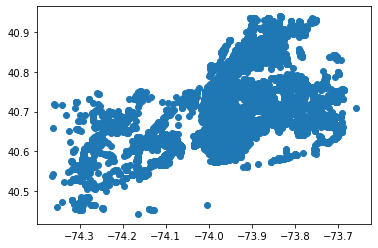

In [12]:
# visualizing the longitude and latitude
plt.scatter(x=df_business_v3['longitude'], y=df_business_v3['latitude'])
plt.show()

Read in Review Data

In [13]:
df_review1 = pd.read_csv('data/csv_files/reviews_nlp_1.csv')
df_review2 = pd.read_csv('data/csv_files/reviews_nlp_2.csv')
df_review3 = pd.read_csv('data/csv_files/reviews_nlp_3.csv')
df_review4 = pd.read_csv('data/csv_files/reviews_nlp_4.csv')
df_review5 = pd.read_csv('data/csv_files/reviews_nlp_5.csv')

In [14]:
df_review1.head()

,id,author,rating,clean_text,labels_final,scores_final
0,DRitJoNGTkHXZvH_YpLIAw,Emme M.,5,fantastic meal client dinner marc brought chic...,Positive,0.932390
1,c8y-_zep3HT3e_RS5zyp-A,Frank A.,3,emmett grove not half pizza place original emm...,Positive,0.460718
2,_hLxV5bkq975qK97Whbtcg,Sha Y.,1,word place racist not hispanic treat like garb...,Negative,-0.900122
3,CDHPw3Jb7iFsNOPIDWNhLg,Robert M.,1,lunch first time since pandemic always liked r...,Negative,-0.534608
4,HqVdTKCpOZWrCvUF9rG2sA,Gene L.,4,place usually keeps busy combination locals re...,Positive,0.796447


In [15]:
# Union all review data
review_all = [df_review1, df_review2, df_review3, df_review4, df_review5]

df_review_final = pd.concat(review_all)
df_review_final = df_review_final.drop(columns=['author', 'rating', 'clean_text'])
df_review_final.head()

,id,labels_final,scores_final
0,DRitJoNGTkHXZvH_YpLIAw,Positive,0.932390
1,c8y-_zep3HT3e_RS5zyp-A,Positive,0.460718
2,_hLxV5bkq975qK97Whbtcg,Negative,-0.900122
3,CDHPw3Jb7iFsNOPIDWNhLg,Negative,-0.534608
4,HqVdTKCpOZWrCvUF9rG2sA,Positive,0.796447


In [16]:
df_review_final.shape

(315711, 3)

In [17]:
df_review_final.groupby('labels_final').agg({'scores_final': ['mean', 'median', 'min', 'max']})

scores_final                              
                     mean    median       min       max
labels_final                                           
Negative        -0.605170 -0.664194 -0.998934 -0.000009
Positive         0.712366  0.806716  0.000031  0.988369

In [18]:
df_review_final['id'].nunique()

16592

Get the average review per restaurant

In [19]:
df_review_agg = df_review_final.groupby('id').agg({'scores_final': 'mean'}).rename(columns={"scores_final": "nlp_avg_score"})

In [20]:
df_review_agg.head()

,nlp_avg_score
id,
#VALUE!,0.373508
-0YTqofxupHzmd9SbKhjXw,0.628995
-0bdnX762vdTb9lI00etvA,0.556301
-0dvsDxtXJEYhgH_FgzZEw,0.776078
-0fjWWC2SY6kNxGfD8PKGg,0.441995


In [21]:
df_review_agg.shape

(16592, 1)

Join review data and business data

In [22]:
df_join = pd.merge(df_business_v3, df_review_agg, on='id', how='inner')

In [23]:
df_join.head()

,id,name,review_count,rating,latitude,longitude,price,city,nlp_avg_score
0,FaR-Kv-0ZzgcqFW1sCnacw,Citizens Of Chelsea,1028,4.0,40.748100,-74.000569,$$,New York,0.550344
1,IOHaEgK1zDvUvB3SfKuGCw,Parker & Quinn,1647,4.0,40.752586,-73.985071,$$,New York,0.560883
2,OOAFPiztVlStZIUDwcixqA,Miznon,117,4.0,40.753520,-74.000120,$$,New York,0.607631
3,Ve6GVzzJpR5QIIPdcn6ViQ,Mercato,1053,4.0,40.756190,-73.993700,$$$,New York,0.493799
4,VqgqLjiOYAydLXOemivxWw,In Common NYC,124,4.5,40.753820,-73.996220,NaN,New York,0.411611


In [24]:
df_join.shape

(16033, 9)

Select final columns for spatial clustering

In [25]:
df_join.columns

Index(['id', 'name', 'review_count', 'rating', 'latitude', 'longitude',
       'price', 'city', 'nlp_avg_score'],
      dtype='object')

In [26]:
# set index using id column so we can join back to original data at last
df_join = df_join.set_index('id')
df_join.head()

,name,review_count,rating,latitude,longitude,price,city,nlp_avg_score
id,,,,,,,,
FaR-Kv-0ZzgcqFW1sCnacw,Citizens Of Chelsea,1028,4.0,40.748100,-74.000569,$$,New York,0.550344
IOHaEgK1zDvUvB3SfKuGCw,Parker & Quinn,1647,4.0,40.752586,-73.985071,$$,New York,0.560883
OOAFPiztVlStZIUDwcixqA,Miznon,117,4.0,40.753520,-74.000120,$$,New York,0.607631
Ve6GVzzJpR5QIIPdcn6ViQ,Mercato,1053,4.0,40.756190,-73.993700,$$$,New York,0.493799
VqgqLjiOYAydLXOemivxWw,In Common NYC,124,4.5,40.753820,-73.996220,NaN,New York,0.411611


In [27]:
# select the final columns needed for clustering
df_cluster = df_join[['latitude', 'longitude', 'review_count', 'rating', 'nlp_avg_score']]

In [28]:
df_cluster.columns

Index(['latitude', 'longitude', 'review_count', 'rating', 'nlp_avg_score'], dtype='object')

Scale input data

Note that Geospatial variables, such as longitude and latitude, don't need to be scaled for many geospatial analysis and clustering tasks because scaling these values can alter their geographic significance and make it difficult to interpret results in the context of real-world locations. Another reason is many clustering algorithms, including DBSCAN and K-Means, can handle geospatial data without requiring scaling. These algorithms work with the raw latitude and longitude values in their natural units.

When DBSCAN to cluster a combination of geospatial and non-geospatial variables, it's generally recommended to use Euclidean distances (Min-Max scaling) for the non-geospatial variables. Here's why:

DBSCAN and Distance-Based Clustering: DBSCAN is a density-based clustering algorithm that primarily relies on distance measures to identify dense regions in your data space. It forms clusters by considering data points that are within a specified distance (eps) of each other. Therefore, preserving the original distances between data points is crucial for DBSCAN to function effectively.

Maintaining Distance Relationships: By scaling your non-geospatial variables using Min-Max scaling, you preserve the relative differences and relationships between data points while ensuring that all variables are on a common scale. This helps DBSCAN accurately identify dense regions based on both geospatial and non-geospatial features.

In [29]:
MinMaxscal = MinMaxScaler()
df_cluster_dbscan = df_cluster.copy()
df_cluster_dbscan[['review_count', 'rating', 'nlp_avg_score']] = MinMaxscal.fit_transform(df_cluster_dbscan[['review_count', 'rating', 'nlp_avg_score']])

# Fit and transform the data to scale it to [0, 1]
# scaled_data = scaler.fit_transform(data)
# rating_distances = euclidean_distances(df_cluster[['review_count', 'rating']].values) * added_km_per_rating_gap

In [30]:
df_cluster_dbscan.head()

,latitude,longitude,review_count,rating,nlp_avg_score
id,,,,,
FaR-Kv-0ZzgcqFW1sCnacw,40.748100,-74.000569,0.066859,0.750,0.790632
IOHaEgK1zDvUvB3SfKuGCw,40.752586,-73.985071,0.107513,0.750,0.796388
OOAFPiztVlStZIUDwcixqA,40.753520,-74.000120,0.007027,0.750,0.821919
Ve6GVzzJpR5QIIPdcn6ViQ,40.756190,-73.993700,0.068501,0.750,0.759750
VqgqLjiOYAydLXOemivxWw,40.753820,-73.996220,0.007487,0.875,0.714863


In [31]:
scaler = StandardScaler()
df_cluster_kmean = df_cluster.copy()
df_cluster_kmean[['review_count', 'rating', 'nlp_avg_score']] = scaler.fit_transform(df_cluster_kmean[['review_count', 'rating', 'nlp_avg_score']])

In [32]:
df_cluster_kmean.head()

,latitude,longitude,review_count,rating,nlp_avg_score
id,,,,,
FaR-Kv-0ZzgcqFW1sCnacw,40.748100,-74.000569,1.939175,0.403947,0.572906
IOHaEgK1zDvUvB3SfKuGCw,40.752586,-73.985071,3.403147,0.403947,0.613975
OOAFPiztVlStZIUDwcixqA,40.753520,-74.000120,-0.215394,0.403947,0.796139
Ve6GVzzJpR5QIIPdcn6ViQ,40.756190,-73.993700,1.998301,0.403947,0.352563
VqgqLjiOYAydLXOemivxWw,40.753820,-73.996220,-0.198839,1.143526,0.032298


In [33]:
df_scale_all = df_cluster.copy()
df_scale_all[['latitude', 'longitude', 'review_count', 'rating', 'nlp_avg_score']] = scaler.fit_transform(df_scale_all[['latitude', 'longitude','review_count', 'rating', 'nlp_avg_score']])

Define Functions for clustering

In [34]:
# define a function to calculate the geographic coordinate 
# centroid of a cluster of geographic points
# it will be used later to calculate the centroids of cluster
# because Scikit-learn DBSCAN cluster class does not come with centroid attribute.
def get_centroid(cluster):
    """calculate the centroid of a cluster of geographic coordinate points
    Args:
    cluster coordinates, nx2 array-like (array, list of lists, etc) 
    n is the number of points(latitude, longitude)in the cluster.
    Return:
    geometry centroid of the cluster
    
    """
    cluster_ary = np.asarray(cluster)
    centroid = cluster_ary.mean(axis = 0)
    
    return centroid

In [35]:
def dbscan_cluster(coords,epsilon,min_samples):
    '''
    Function to perform DBSCAN clustering for given parameters.
    # minPts should be 2 * number of dimensions
    '''
    
    # convert epsilon from km to radians
    kms_per_radian = 6371.0088
    epsilon /= kms_per_radian
    
    # set up the algorithm
    dbscan = DBSCAN(
        eps = epsilon,
        min_samples = min_samples,
        algorithm = 'ball_tree'
    ).fit(np.radians(coords))
    
    # return the cluster labels
    return pd.Series(dbscan.labels_)

In [36]:
def combine_spatial_temporal(X, n_temporal):
    pca = PCA(n_components = n_temporal)
    X_pca = pca.fit_transform(X[:, 2:])
    X = np.hstack((X[:, :2], X_pca))
    
    # scale the data
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    return X_std

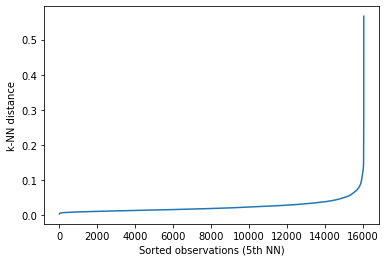

In [37]:
#dbscan epsilon elbow method
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros)
nbrs = NearestNeighbors(n_neighbors=5).fit(df_cluster_dbscan)

# Find the k-neighbors of a point
distances, indices = nbrs.kneighbors(df_cluster_dbscan)

# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(distances, axis=0)
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (5th NN)")
plt.show()

In [38]:
kneedle = KneeLocator(x = range(1, len(distances) + 1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
print(kneedle.knee_y)

0.1284796471676827


Tuning DBSCAN Parameters

In [39]:
epsilon = np.linspace(1, 20, num=30)
epsilon

array([ 1.        ,  1.65517241,  2.31034483,  2.96551724,  3.62068966,
        4.27586207,  4.93103448,  5.5862069 ,  6.24137931,  6.89655172,
        7.55172414,  8.20689655,  8.86206897,  9.51724138, 10.17241379,
       10.82758621, 11.48275862, 12.13793103, 12.79310345, 13.44827586,
       14.10344828, 14.75862069, 15.4137931 , 16.06896552, 16.72413793,
       17.37931034, 18.03448276, 18.68965517, 19.34482759, 20.        ])

In [40]:
min_samples = np.arange(5, 45, step=5)
min_samples

array([ 5, 10, 15, 20, 25, 30, 35, 40])

In [41]:
combinations = list(itertools.product(epsilon, min_samples))
N = len(combinations)
N

240

In [42]:
def Gridsearch(combination, df):
    scores = []
    all_label = []
    
    for i, (eps, num_samples) in enumerate(combination):
        labels = dbscan_cluster(df, eps, num_samples)
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -= 1
        if (num_clusters < 2):
            scores.append(-20)
            all_label.append("Poor")
            print(" at iteration : ", i, "ep = ", eps, "min_samples = ", num_samples, 
                  "number of cluster = ", num_clusters, "moving on .. ")
            continue
        scores.append(silhouette_score(df, labels))
        all_label.append(labels)
        print(" at iteration :", i, "ep = ", eps, "min_samples = ", num_samples, 
              "score :", scores[-1], "number of clusters :", num_clusters)
    
    best_index = np.argmax(scores)
    best_parameters = combination[best_index]
    best_labels = all_label[best_index]
    best_score = scores[best_index]
    
    return{"best_epsilon": best_parameters[0],
           "best_min_samples": best_parameters[1],
           "best_labels": best_labels,
           "best_score": best_score}

In [43]:
db_dbscan_v2 = df_cluster_dbscan[['latitude', 'longitude', 'rating', 'nlp_avg_score']]
best_para = Gridsearch(combinations, db_dbscan_v2)

 at iteration : 0 ep =  1.0 min_samples =  5 score : -0.5611485843568064 number of clusters : 208
 at iteration : 1 ep =  1.0 min_samples =  10 score : -0.5374701053533832 number of clusters : 33
 at iteration : 2 ep =  1.0 min_samples =  15 score : -0.4475110063073939 number of clusters : 10
 at iteration : 3 ep =  1.0 min_samples =  20 score : -0.40875325009122393 number of clusters : 14
 at iteration : 4 ep =  1.0 min_samples =  25 score : -0.3048875128028199 number of clusters : 3
 at iteration : 5 ep =  1.0 min_samples =  30 score : -0.2817861537506238 number of clusters : 2
 at iteration :  6 ep =  1.0 min_samples =  35 number of cluster =  0 moving on .. 
 at iteration :  7 ep =  1.0 min_samples =  40 number of cluster =  0 moving on .. 
 at iteration : 8 ep =  1.6551724137931034 min_samples =  5 score : -0.4630046914833503 number of clusters : 192
 at iteration : 9 ep =  1.6551724137931034 min_samples =  10 score : -0.4699580015721744 number of clusters : 65
 at iteration : 10 

 at iteration : 74 ep =  6.896551724137931 min_samples =  15 score : 0.1212225804896104 number of clusters : 12
 at iteration : 75 ep =  6.896551724137931 min_samples =  20 score : 0.1236488681662605 number of clusters : 10
 at iteration : 76 ep =  6.896551724137931 min_samples =  25 score : 0.12852475448374526 number of clusters : 12
 at iteration : 77 ep =  6.896551724137931 min_samples =  30 score : 0.1248947520719812 number of clusters : 8
 at iteration : 78 ep =  6.896551724137931 min_samples =  35 score : 0.11600325493109903 number of clusters : 8
 at iteration : 79 ep =  6.896551724137931 min_samples =  40 score : 0.13530610131881943 number of clusters : 6
 at iteration : 80 ep =  7.551724137931034 min_samples =  5 score : 0.16402647948132273 number of clusters : 13
 at iteration : 81 ep =  7.551724137931034 min_samples =  10 score : 0.16434390782392427 number of clusters : 10
 at iteration : 82 ep =  7.551724137931034 min_samples =  15 score : 0.14031452832015753 number of clus

 at iteration : 147 ep =  12.793103448275861 min_samples =  20 score : 0.17557374223060487 number of clusters : 8
 at iteration : 148 ep =  12.793103448275861 min_samples =  25 score : 0.17524573138585015 number of clusters : 8
 at iteration : 149 ep =  12.793103448275861 min_samples =  30 score : 0.17281701791609516 number of clusters : 9
 at iteration : 150 ep =  12.793103448275861 min_samples =  35 score : 0.17424901165360568 number of clusters : 7
 at iteration : 151 ep =  12.793103448275861 min_samples =  40 score : 0.17330625670913466 number of clusters : 7
 at iteration : 152 ep =  13.448275862068964 min_samples =  5 score : 0.17782810395975712 number of clusters : 9
 at iteration : 153 ep =  13.448275862068964 min_samples =  10 score : 0.17627275693512964 number of clusters : 9
 at iteration : 154 ep =  13.448275862068964 min_samples =  15 score : 0.1755738636521265 number of clusters : 9
 at iteration : 155 ep =  13.448275862068964 min_samples =  20 score : 0.1759843136563162 

 at iteration :  227 ep =  19.344827586206897 min_samples =  20 number of cluster =  1 moving on .. 
 at iteration :  228 ep =  19.344827586206897 min_samples =  25 number of cluster =  1 moving on .. 
 at iteration :  229 ep =  19.344827586206897 min_samples =  30 number of cluster =  1 moving on .. 
 at iteration :  230 ep =  19.344827586206897 min_samples =  35 number of cluster =  1 moving on .. 
 at iteration :  231 ep =  19.344827586206897 min_samples =  40 number of cluster =  1 moving on .. 
 at iteration :  232 ep =  20.0 min_samples =  5 number of cluster =  1 moving on .. 
 at iteration :  233 ep =  20.0 min_samples =  10 number of cluster =  1 moving on .. 
 at iteration :  234 ep =  20.0 min_samples =  15 number of cluster =  1 moving on .. 
 at iteration :  235 ep =  20.0 min_samples =  20 number of cluster =  1 moving on .. 
 at iteration :  236 ep =  20.0 min_samples =  25 number of cluster =  1 moving on .. 
 at iteration :  237 ep =  20.0 min_samples =  30 number of c

Build final dbscan cluster and plot result

In [48]:
labels = dbscan_cluster(db_dbscan_v2, 12.8, 5)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
sil_score = silhouette_score(db_dbscan_v2, labels)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print('Silhouette coefficient: {:0.03f}'.format(sil_score))

Estimated number of clusters: 10
Estimated number of noise points: 16
Silhouette coefficient: 0.178


In [49]:
# get each cluster set
Counter(labels)

Counter({0: 5408,
         1: 3123,
         2: 3799,
         3: 369,
         4: 1841,
         5: 965,
         7: 102,
         6: 393,
         -1: 16,
         8: 17})

In [63]:
dbscan_result = df_cluster.assign(dbscan_cluster= labels.values)
dbscan_result.head()

,latitude,longitude,review_count,rating,nlp_avg_score,dbscan_cluster
id,,,,,,
FaR-Kv-0ZzgcqFW1sCnacw,40.748100,-74.000569,1028,4.0,0.550344,0
IOHaEgK1zDvUvB3SfKuGCw,40.752586,-73.985071,1647,4.0,0.560883,0
OOAFPiztVlStZIUDwcixqA,40.753520,-74.000120,117,4.0,0.607631,0
Ve6GVzzJpR5QIIPdcn6ViQ,40.756190,-73.993700,1053,4.0,0.493799,0
VqgqLjiOYAydLXOemivxWw,40.753820,-73.996220,124,4.5,0.411611,1


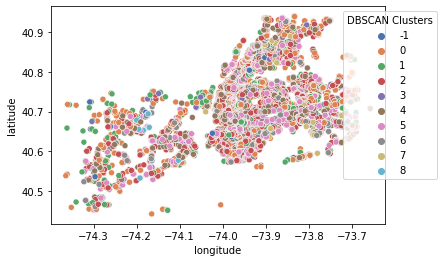

In [65]:
p = sns.scatterplot(data = dbscan_result, x = "longitude", y = "latitude", hue = "dbscan_cluster", legend = "full", palette = "deep")
sns.move_legend(p, "upper right", bbox_to_anchor = (1.17, 1.), title = 'DBSCAN Clusters')
plt.show()

K-mean Clustering

In [53]:
kmean_array  = np.array(df_cluster_kmean)
kmean_array

array([[ 40.74809983, -74.000569  ,   1.93917482,   0.40394744,
          0.57290596],
       [ 40.75258622, -73.98507132,   3.40314673,   0.40394744,
          0.61397489],
       [ 40.75352   , -74.00012   ,  -0.21539449,   0.40394744,
          0.796139  ],
       ...,
       [ 40.56121434, -73.92084916,  -0.17282342,   0.40394744,
          1.41708409],
       [ 40.57298   , -73.85514   ,  -0.46372575,   1.14352599,
          0.98290455],
       [ 40.5608959 , -73.9114797 ,  -0.46136069,   0.40394744,
         -0.24473661]])

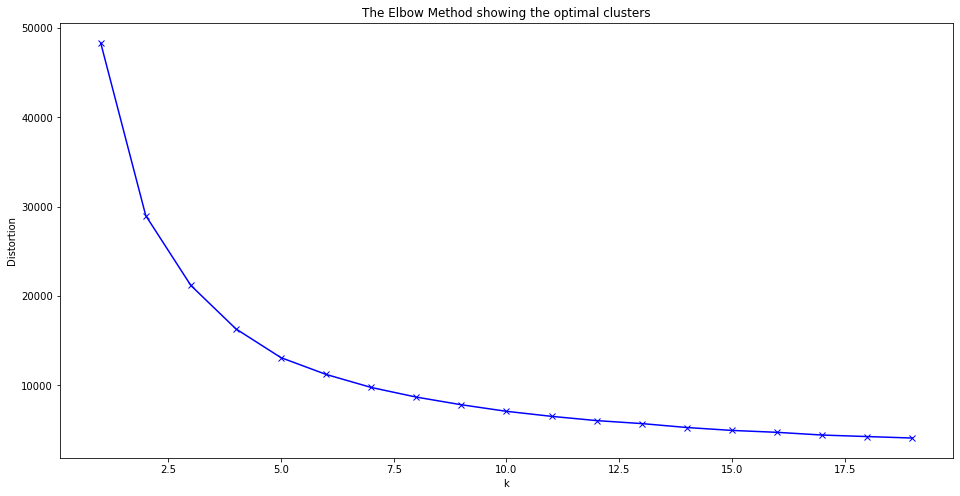

In [54]:
# Collecting the distortions into list
distortions = []
silhouette_avg = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state = 42)
    kmeanModel.fit(kmean_array)
    distortions.append(kmeanModel.inertia_)
    
# Plotting the distortions
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal clusters')
plt.show()

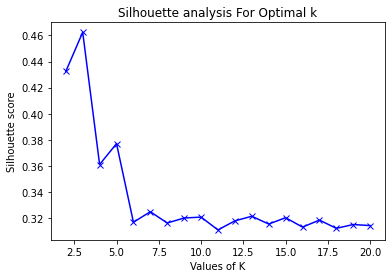

In [55]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters = num_clusters, random_state=42)
    kmeans.fit(kmean_array)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(kmean_array, cluster_labels))
    
plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

We see that the silhouette score is maximized at k = 3. While kmeans elbow seems to be around 5.
Let's first fit using 5

In [56]:
# Define the model
kmeans_model = KMeans(n_clusters=5, random_state=42)

# Fit into our dataset fit
kmeans_predict = kmeans_model.fit_predict(kmean_array)

In [57]:
silhouette_score(kmean_array, kmeans_predict)

0.3770549280682267

In [58]:
kmean_result = df_cluster.copy()
kmean_result['kmean_cluster'] = kmeans_predict
kmean_result.head()

,latitude,longitude,review_count,rating,nlp_avg_score,kmean_cluster
id,,,,,,
FaR-Kv-0ZzgcqFW1sCnacw,40.748100,-74.000569,1028,4.0,0.550344,0
IOHaEgK1zDvUvB3SfKuGCw,40.752586,-73.985071,1647,4.0,0.560883,0
OOAFPiztVlStZIUDwcixqA,40.753520,-74.000120,117,4.0,0.607631,3
Ve6GVzzJpR5QIIPdcn6ViQ,40.756190,-73.993700,1053,4.0,0.493799,0
VqgqLjiOYAydLXOemivxWw,40.753820,-73.996220,124,4.5,0.411611,3


In [60]:
kmean_result.groupby('kmean_cluster').agg('count')

,latitude,longitude,review_count,rating,nlp_avg_score
kmean_cluster,,,,,
0,1116,1116,1116,1116,1116
1,2311,2311,2311,2311,2311
2,5665,5665,5665,5665,5665
3,6876,6876,6876,6876,6876
4,65,65,65,65,65


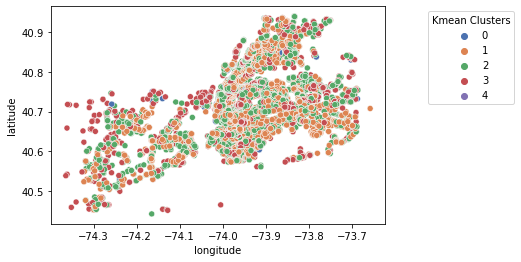

In [61]:
p = sns.scatterplot(data = kmean_result, x = "longitude", y = "latitude", hue = kmeans_predict, legend = "full", palette = "deep")
sns.move_legend(p, "upper right", bbox_to_anchor = (1.4, 1.), title = 'Kmean Clusters')
plt.show()

Cluster with K = 3

In [67]:
# Define the model
kmeans_model3 = KMeans(n_clusters=3, random_state=42)

# Fit into our dataset fit
kmeans_predict3 = kmeans_model3.fit_predict(kmean_array)
silhouette_score(kmean_array, kmeans_predict3)

0.46248277332620624

In [71]:
kmean_result_3k = df_cluster.copy()
kmean_result_3k['kmean_cluster_3k'] = kmeans_predict3
kmean_result_3k.groupby('kmean_cluster_3k').agg('count')

,latitude,longitude,review_count,rating,nlp_avg_score
kmean_cluster_3k,,,,,
0,479,479,479,479,479
1,4819,4819,4819,4819,4819
2,10735,10735,10735,10735,10735


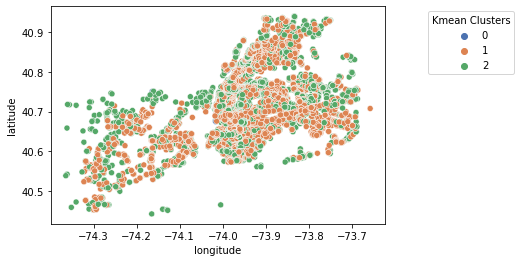

In [72]:
p = sns.scatterplot(data = kmean_result_3k, x = "longitude", y = "latitude", 
                    hue = kmeans_predict3, legend = "full", palette = "deep")
sns.move_legend(p, "upper right", bbox_to_anchor = (1.4, 1.), title = 'Kmean Clusters')
plt.show()

PCA to combined spatial and temporal data

In [78]:
# PCA & data scale for all columns
X = df_cluster.values
n_components = 2
kmean_array_pca = combine_spatial_temporal(X, n_components)

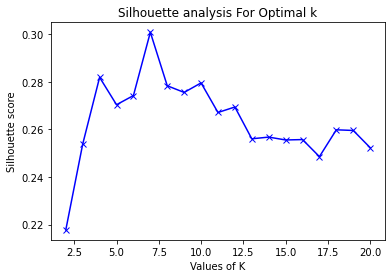

In [79]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(kmean_array_pca)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(kmean_array_pca, cluster_labels))
    
plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [80]:
def plot_spatial_temporal_clustering_result(kmean, n_components, k, Xs, df_all):
    n = len(k)
    plt.subplots(nrows=n, ncols=1, figsize=(15,30))

    for i in range(n):
        est = kmean[i]
        clusteri = 'cluster' + str(i)
        df_all[clusteri] = est.predict(Xs).tolist()
        shs = silhouette_score(Xs, kmean[i].predict(Xs))

        ax = plt.subplot(n, 2, 2*i+1)
        ax.set_title("Spatial-Temporal Clustering with KMeans (#temporal features={}, k={}, silhouette_score={})".format(n_components, k[i], shs))
        p = sns.scatterplot(data = df_all, x = "longitude", y = "latitude", 
                    hue = df_all[clusteri], legend = "full", palette = "deep")
        sns.move_legend(p, "upper right", bbox_to_anchor = (1.4, 1.), title = 'Kmean Clusters')

In [81]:
k = [2, 3, 4, 5, 6, 7, 8]
kmean = [KMeans(n_clusters=ki, random_state=42).fit(kmean_array_pca) for ki in k]

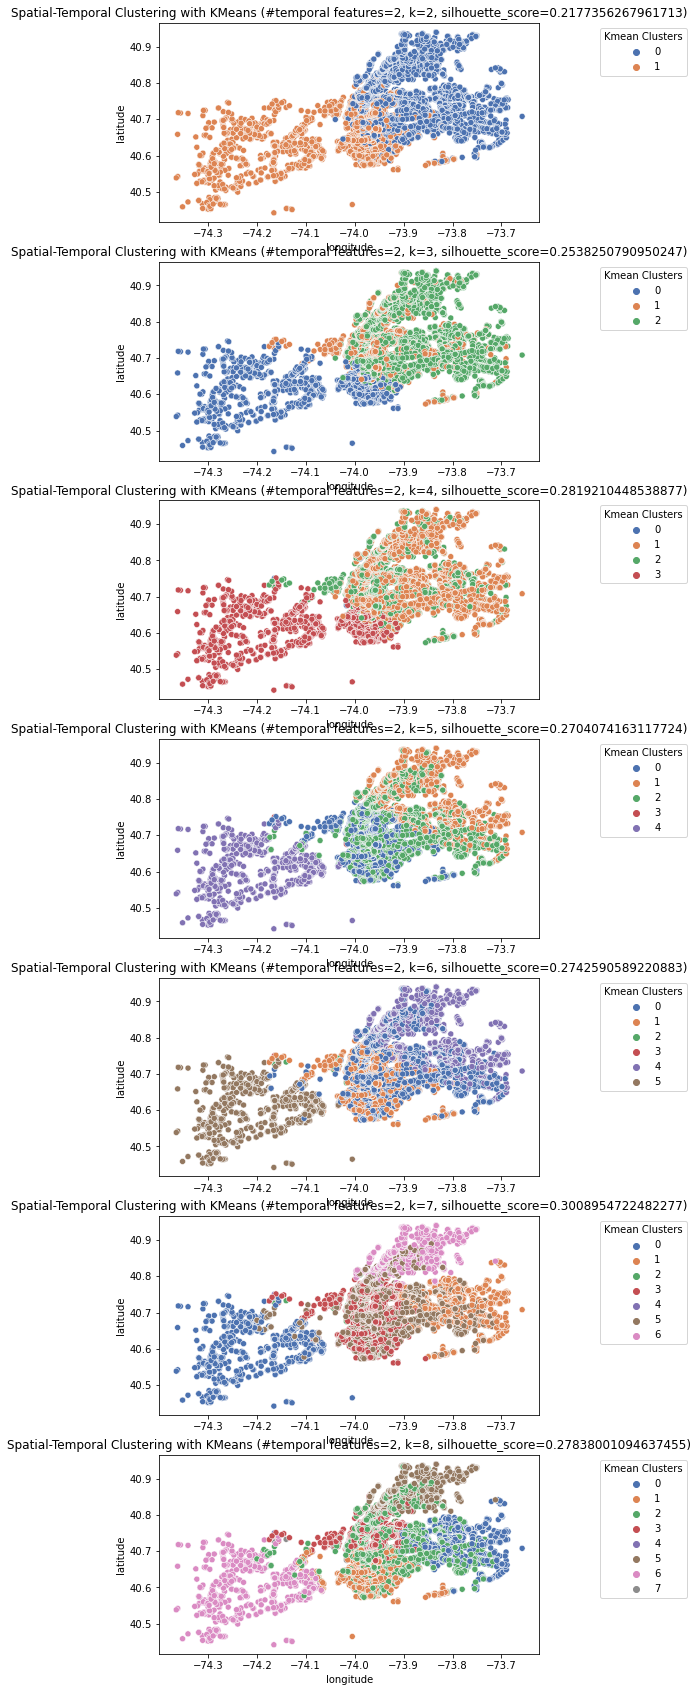

In [82]:
df_kmean_pca = df_cluster.copy()
plot_spatial_temporal_clustering_result(kmean, n_components, k, kmean_array_pca, df_kmean_pca)

In [83]:
df_kmean_pca.head()

,latitude,longitude,review_count,rating,nlp_avg_score,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
id,,,,,,,,,,,,
FaR-Kv-0ZzgcqFW1sCnacw,40.748100,-74.000569,1028,4.0,0.550344,1,1,2,0,2,2,7
IOHaEgK1zDvUvB3SfKuGCw,40.752586,-73.985071,1647,4.0,0.560883,1,1,0,3,2,2,7
OOAFPiztVlStZIUDwcixqA,40.753520,-74.000120,117,4.0,0.607631,1,1,2,0,1,3,3
Ve6GVzzJpR5QIIPdcn6ViQ,40.756190,-73.993700,1053,4.0,0.493799,1,1,0,0,2,2,7
VqgqLjiOYAydLXOemivxWw,40.753820,-73.996220,124,4.5,0.411611,1,1,2,0,1,3,3


In [84]:
# View the best cluster result
df_kmean_pca.groupby('cluster5').agg('count')

,latitude,longitude,review_count,rating,nlp_avg_score,cluster0,cluster1,cluster2,cluster3,cluster4,cluster6
cluster5,,,,,,,,,,,
0,1078,1078,1078,1078,1078,1078,1078,1078,1078,1078,1078
1,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
2,1179,1179,1179,1179,1179,1179,1179,1179,1179,1179,1179
3,7494,7494,7494,7494,7494,7494,7494,7494,7494,7494,7494
4,64,64,64,64,64,64,64,64,64,64,64
5,2324,2324,2324,2324,2324,2324,2324,2324,2324,2324,2324
6,1877,1877,1877,1877,1877,1877,1877,1877,1877,1877,1877


Hierarchical Clustering

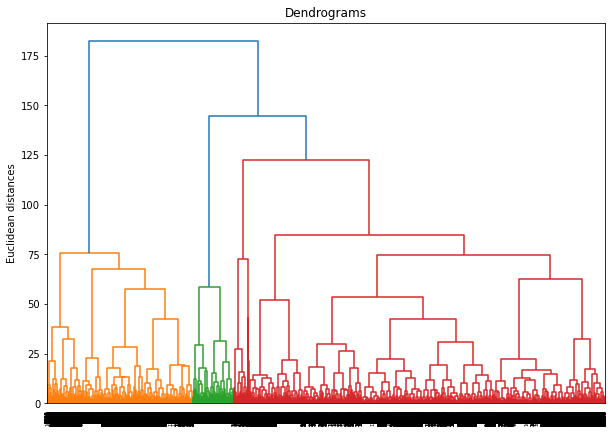

In [91]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
plt.ylabel('Euclidean distances')
dend = dendrogram(sch.linkage(df_scale_all, method='ward'))
plt.show()

We try to set the threshold in such a way that it cuts the tallest vertical line. From that dendrogram above we can set the threshold as = 100 and we can see from the output below : the horizontal line crossing 4 vertical lines.

In [92]:
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(df_scale_all)

In [93]:
df_cluster_hc = df_scale_all.copy()
df_cluster_hc['hc_cluster'] = y_hc
df_cluster_hc.groupby('hc_cluster').agg('count')

,latitude,longitude,review_count,rating,nlp_avg_score
hc_cluster,,,,,
0,10226,10226,10226,10226,10226
1,4192,4192,4192,4192,4192
2,1175,1175,1175,1175,1175
3,440,440,440,440,440


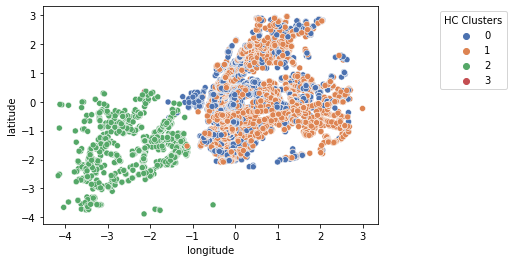

In [94]:
p = sns.scatterplot(data = df_cluster_hc, x = "longitude", y = "latitude", 
                    hue = y_hc, legend = "full", palette = "deep")
sns.move_legend(p, "upper right", bbox_to_anchor = (1.4, 1.), title = 'HC Clusters')
plt.show()

HC without scaled data

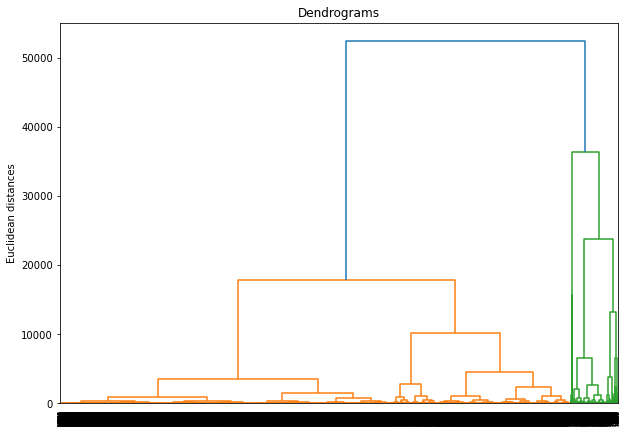

In [95]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
plt.ylabel('Euclidean distances')
dend2 = dendrogram(sch.linkage(df_cluster, method='ward'))
plt.show()

From that dendrogram above we can set the threshold as = 30000 and we can see from the output below : the horizontal line crossing 3 vertical lines.

In [96]:
hc2 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc2 = hc2.fit_predict(df_scale_all)

In [97]:
df_cluster_hc2 = df_scale_all.copy()
df_cluster_hc2['hc_cluster'] = y_hc2
df_cluster_hc2.groupby('hc_cluster').agg('count')

,latitude,longitude,review_count,rating,nlp_avg_score
hc_cluster,,,,,
0,10666,10666,10666,10666,10666
1,4192,4192,4192,4192,4192
2,1175,1175,1175,1175,1175


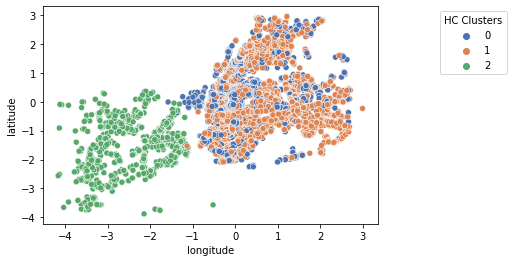

In [98]:
p = sns.scatterplot(data = df_cluster_hc2, x = "longitude", y = "latitude", 
                    hue = y_hc2, legend = "full", palette = "deep")
sns.move_legend(p, "upper right", bbox_to_anchor = (1.4, 1.), title = 'HC Clusters')
plt.show()

Output final data

Based on the different clustering method, it seems like PCA and kmeans with k=7 yields the best result visually, with a silhouette score of 0.30. We will output the cluster based on this model

In [85]:
# join final cluster with remaining info
df_bus = df_business[['id', 'name', 'review_count', 'categories1', 'categories2', 'categories3', 
                      'rating', 'price', 'address1', 'address2', 'address3', 'city', 'zip_code']]
df_kmean_final = df_kmean_pca[['latitude', 'longitude', 'nlp_avg_score', 'cluster5']]

In [86]:
# rename column
df_kmean_final.rename(columns={"cluster5": "kmean_cluster_7k"}).head()

,latitude,longitude,nlp_avg_score,kmean_cluster_7k
id,,,,
FaR-Kv-0ZzgcqFW1sCnacw,40.748100,-74.000569,0.550344,2
IOHaEgK1zDvUvB3SfKuGCw,40.752586,-73.985071,0.560883,2
OOAFPiztVlStZIUDwcixqA,40.753520,-74.000120,0.607631,3
Ve6GVzzJpR5QIIPdcn6ViQ,40.756190,-73.993700,0.493799,2
VqgqLjiOYAydLXOemivxWw,40.753820,-73.996220,0.411611,3


In [87]:
#convert index back to id
df_kmean_final = df_kmean_final.reset_index()
df_kmean_final.head()

,id,latitude,longitude,nlp_avg_score,cluster5
0,FaR-Kv-0ZzgcqFW1sCnacw,40.748100,-74.000569,0.550344,2
1,IOHaEgK1zDvUvB3SfKuGCw,40.752586,-73.985071,0.560883,2
2,OOAFPiztVlStZIUDwcixqA,40.753520,-74.000120,0.607631,3
3,Ve6GVzzJpR5QIIPdcn6ViQ,40.756190,-73.993700,0.493799,2
4,VqgqLjiOYAydLXOemivxWw,40.753820,-73.996220,0.411611,3


In [89]:
cluster_result = pd.merge(df_bus, df_kmean_final, on='id', how='inner')
cluster_result.head()

,id,name,review_count,categories1,categories2,categories3,rating,price,address1,address2,address3,city,zip_code,latitude,longitude,nlp_avg_score,cluster5
0,FaR-Kv-0ZzgcqFW1sCnacw,Citizens Of Chelsea,1028,coffee,breakfast_brunch,australian,4.0,$$,401 W 25th St,NaN,NaN,New York,10001,40.748100,-74.000569,0.550344,2
1,IOHaEgK1zDvUvB3SfKuGCw,Parker & Quinn,1647,newamerican,bars,breakfast_brunch,4.0,$$,64 W 39th St,NaN,NaN,New York,10018,40.752586,-73.985071,0.560883,2
2,OOAFPiztVlStZIUDwcixqA,Miznon,117,sandwiches,mediterranean,bars,4.0,$$,20 Hudson Yards,NaN,NaN,New York,10001,40.753520,-74.000120,0.607631,3
3,Ve6GVzzJpR5QIIPdcn6ViQ,Mercato,1053,italian,cocktailbars,desserts,4.0,$$$,352 W 39th St,NaN,NaN,New York,10018,40.756190,-73.993700,0.493799,2
4,VqgqLjiOYAydLXOemivxWw,In Common NYC,124,cafes,breakfast_brunch,NaN,4.5,NaN,441 9th Ave,NaN,NaN,New York,10001,40.753820,-73.996220,0.411611,3


In [90]:
cluster_result.to_csv('cluster_result.csv', header=True, index=False)